# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Tue Aug  5 23:17:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              6W /   60W |     375MiB /   4096MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [2]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import json
import optuna
import shutil

import torch
from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [3]:
selected_model = "yolov12s" 
model_dir = "yolo_output/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")

if selected_model not in config.models:
    model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"

### **Optuna**

In [ ]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-08-07 17:57:32,461] A new study created in RDB with name: yolov12s


New https://pypi.org/project/ultralytics/8.3.175 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.pt, momentum=0.9097990912717108, mosaic=0, multi_

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


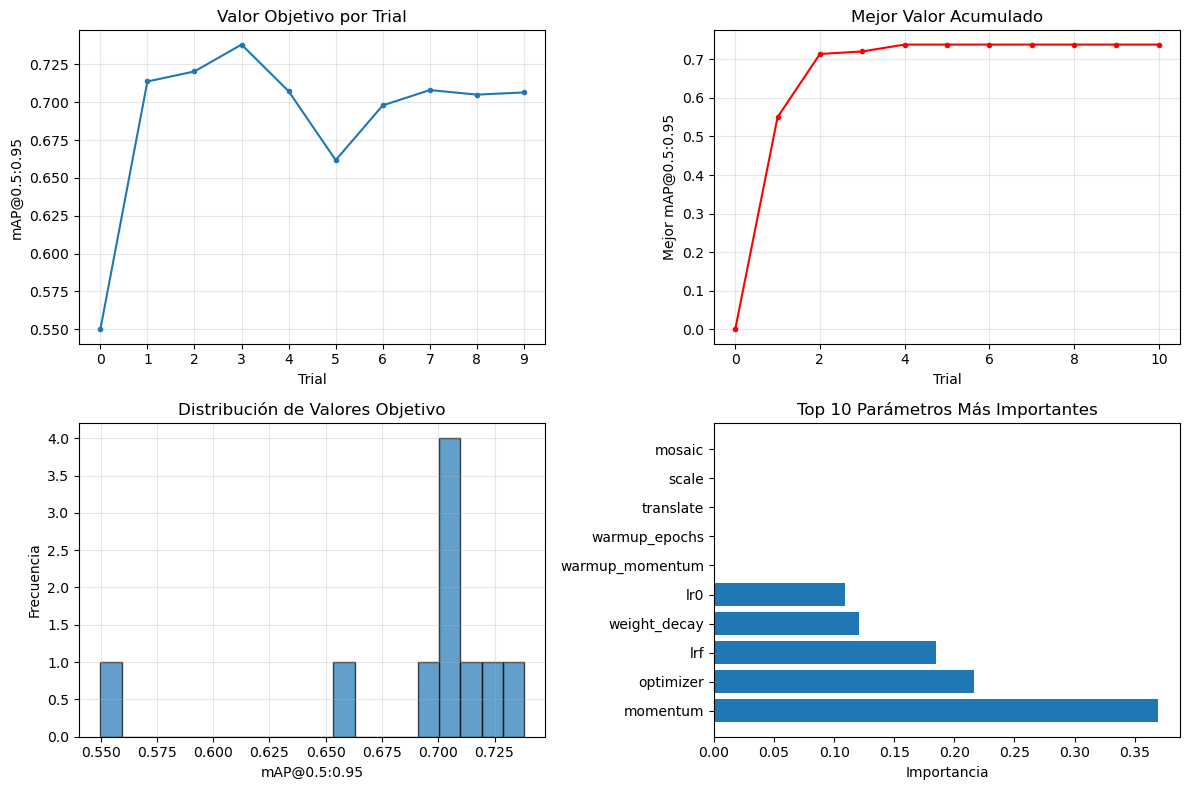

In [6]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [5]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.00023426581058204064
  lrf: 0.009323621351781481
  momentum: 0.9162699235041671
  weight_decay: 0.0008699593128513321
  optimizer: AdamW


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [10]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)


Entrenando fold_1 (1/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.8549542764940538, m

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 658.60it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.32.4 MB/s, size: 107.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 388.89it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_1\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_1
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.15G     0.7957     0.6039     0.8221         80        704: 100%|██████████| 47/47 [01:49<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all         70        881      0.857      0.842      0.912      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.93G     0.7938     0.6095     0.8275         14        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70        881      0.857      0.843      0.912      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.87G     0.8214     0.6184     0.8271         37        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all         70        881       0.85      0.844      0.912      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.91G     0.8133     0.6212      0.827         63        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70        881      0.853      0.844      0.913      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.98G     0.7961     0.6061     0.8235         51        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all         70        881      0.855      0.844      0.913       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.94G     0.8123     0.6108     0.8281         36        704: 100%|██████████| 47/47 [01:31<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all         70        881      0.858      0.843      0.913      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.88G     0.7829      0.615     0.8225         72        704: 100%|██████████| 47/47 [00:48<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70        881      0.854      0.848      0.913       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7901     0.5991     0.8269         57        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70        881      0.853      0.848      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.97G     0.8377     0.6186     0.8286         64        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all         70        881      0.857      0.847      0.913      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.87G     0.8004     0.5991       0.82         55        704: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all         70        881      0.855      0.845      0.914      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.89G     0.7998     0.5934     0.8244         42        704: 100%|██████████| 47/47 [01:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all         70        881      0.855      0.847      0.913      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.93G     0.8005     0.6133     0.8301         45        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70        881      0.856      0.846      0.913      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.93G     0.8184     0.6117     0.8275         45        704: 100%|██████████| 47/47 [01:12<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all         70        881      0.861      0.844      0.913      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7877     0.5954     0.8282         86        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all         70        881      0.859      0.846      0.913      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.92G     0.7894     0.6016     0.8242         88        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all         70        881      0.854      0.848      0.913      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.93G     0.7811     0.5993     0.8288         29        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all         70        881      0.853      0.849      0.914      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.8051     0.6062     0.8242         33        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70        881      0.855      0.847      0.914      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.9G     0.8034     0.5897     0.8209         47        704: 100%|██████████| 47/47 [00:47<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all         70        881      0.857      0.846      0.914      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7951     0.6044     0.8228         48        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70        881      0.857      0.844      0.915      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.93G     0.7946     0.6024     0.8275         80        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all         70        881      0.855      0.851      0.915      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7849     0.5971      0.824         24        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all         70        881      0.854      0.846      0.917      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.88G     0.7658     0.5863     0.8222         18        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all         70        881      0.853      0.847      0.915      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.94G     0.7907     0.5883     0.8272         26        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all         70        881      0.856      0.847      0.915      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.96G     0.7838     0.6031     0.8229         87        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all         70        881      0.854       0.85      0.915      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.89G      0.782      0.599     0.8227         54        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70        881      0.851      0.848      0.915      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.96G     0.7966     0.5967     0.8248         38        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all         70        881      0.854      0.847      0.915      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G     0.7868     0.5917     0.8231         85        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70        881      0.855      0.848      0.915      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.89G     0.7867     0.6024     0.8262          9        704: 100%|██████████| 47/47 [00:32<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all         70        881      0.848       0.85      0.914      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.93G     0.7966     0.5988     0.8282         36        704: 100%|██████████| 47/47 [01:03<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all         70        881      0.848       0.85      0.913      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.94G     0.7871     0.5863     0.8213         68        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all         70        881      0.848      0.848      0.915      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7981     0.6005     0.8283         30        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70        881      0.852      0.848      0.914      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.93G     0.8146     0.6037     0.8254         38        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70        881       0.86      0.842      0.915      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.95G     0.8003     0.6106      0.824         54        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         70        881      0.845      0.848      0.914      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.97G     0.7852     0.6017     0.8214         13        704: 100%|██████████| 47/47 [01:06<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70        881       0.86      0.842      0.915      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.93G     0.7677     0.5876     0.8222         43        704: 100%|██████████| 47/47 [00:52<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all         70        881      0.847       0.85      0.915      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       3.9G     0.8038     0.6097     0.8302         60        704: 100%|██████████| 47/47 [01:04<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70        881      0.861      0.838      0.914      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.88G     0.8353     0.6014     0.8295         39        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all         70        881      0.857      0.847      0.915      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.87G     0.7942      0.603     0.8226         85        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all         70        881       0.85      0.852      0.918      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.92G     0.7837     0.5973     0.8226         61        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all         70        881      0.857      0.845      0.915      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.98G      0.812     0.5966     0.8258         75        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all         70        881      0.846       0.85      0.915      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.94G     0.7832     0.6012     0.8248         72        704: 100%|██████████| 47/47 [01:17<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

                   all         70        881      0.846      0.851      0.915      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.89G      0.802     0.6043     0.8271         63        704: 100%|██████████| 47/47 [00:47<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70        881      0.846      0.851      0.914      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.94G     0.8073     0.5997     0.8276         66        704: 100%|██████████| 47/47 [00:50<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70        881      0.845      0.849      0.914      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.94G     0.7868     0.5877     0.8253         25        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all         70        881      0.846      0.849      0.917      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.87G     0.7904     0.6008     0.8267         51        704: 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70        881      0.846      0.854      0.918      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.95G     0.7834     0.5948     0.8215         61        704: 100%|██████████| 47/47 [01:11<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all         70        881       0.86       0.84      0.915      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.88G     0.7826     0.5936     0.8285         77        704: 100%|██████████| 47/47 [01:12<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all         70        881      0.861      0.838      0.915      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.96G     0.7823     0.5912     0.8239         25        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all         70        881      0.848      0.849      0.915      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.95G     0.7759     0.5945     0.8277         57        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70        881      0.845       0.85      0.914      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.92G     0.7903     0.5941     0.8256         29        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all         70        881       0.86      0.839      0.915      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.89G     0.7757     0.5881     0.8235         27        704: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all         70        881      0.848      0.848      0.915      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.93G     0.7745     0.5841     0.8245         64        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all         70        881      0.852      0.847      0.915      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G      0.792     0.6012     0.8234         52        704: 100%|██████████| 47/47 [00:37<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all         70        881      0.847      0.852      0.918      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.95G     0.7776     0.5893       0.82         34        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all         70        881      0.845      0.849      0.914      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7963     0.6081     0.8283         55        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all         70        881      0.851      0.847      0.915      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.95G     0.7862     0.5921     0.8282         29        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all         70        881      0.844      0.847      0.914      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.89G     0.7887     0.5928     0.8245         24        704: 100%|██████████| 47/47 [00:47<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all         70        881      0.846      0.854      0.918      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.88G      0.797     0.5806     0.8242         32        704: 100%|██████████| 47/47 [01:11<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all         70        881      0.852      0.847      0.915      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.93G     0.7989     0.6043     0.8248         75        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70        881      0.847      0.852      0.915      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.89G     0.7957      0.598     0.8251         45        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all         70        881      0.854      0.848      0.915      0.561



60 epochs completed in 1.118 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_1\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_1\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_1\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


                   all         70        881      0.851      0.852      0.918      0.591
Speed: 0.4ms preprocess, 15.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_1

Entrenando fold_2 (2/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 677.46it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 6.71.1 MB/s, size: 103.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 361.96it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_2\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.14G     0.7876     0.6034     0.8227         55        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all         70       1026      0.826      0.872      0.898      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.96G     0.7633     0.5923      0.827         14        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all         70       1026      0.824      0.872      0.897      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.94G     0.7869     0.5929     0.8248         72        704: 100%|██████████| 47/47 [01:22<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all         70       1026      0.826      0.872      0.897      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.89G     0.7819     0.5953     0.8228        115        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all         70       1026      0.823      0.876      0.897      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       3.9G     0.7798     0.5922     0.8225         57        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all         70       1026      0.819       0.88      0.897      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.91G     0.7797     0.5874     0.8225         19        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all         70       1026      0.818      0.877      0.897      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.96G     0.7785     0.5836     0.8198         43        704: 100%|██████████| 47/47 [00:43<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.819       0.88      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7927     0.5961     0.8166         36        704: 100%|██████████| 47/47 [01:15<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1026      0.819      0.881      0.897       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.96G     0.8036     0.6006      0.821         32        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all         70       1026      0.815       0.88      0.897      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.89G     0.7671     0.5933      0.821         30        704: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all         70       1026      0.818      0.879      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.95G      0.783     0.5839     0.8238         53        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all         70       1026      0.815       0.88      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.94G     0.7853     0.5953     0.8214         36        704: 100%|██████████| 47/47 [01:22<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all         70       1026      0.817      0.881      0.898      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.92G     0.8062     0.6074     0.8291         12        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all         70       1026      0.821       0.88      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7757     0.5953     0.8253         61        704: 100%|██████████| 47/47 [01:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.827      0.878      0.898      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7675     0.5901     0.8301         17        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all         70       1026      0.822      0.878      0.898      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.88G     0.7751     0.5954     0.8253         38        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1026      0.821      0.882      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.7665     0.5777     0.8189         18        704: 100%|██████████| 47/47 [00:56<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.824      0.879      0.898      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       3.9G     0.7801     0.5995     0.8198         40        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.827      0.872      0.897      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.96G     0.7952     0.6037     0.8233         51        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all         70       1026       0.83      0.872      0.898       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.96G     0.7836     0.5899     0.8176         30        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all         70       1026      0.826      0.873      0.898      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7633     0.5909     0.8222         90        704: 100%|██████████| 47/47 [01:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.824      0.873      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       3.9G     0.7811     0.5861      0.827         22        704: 100%|██████████| 47/47 [00:38<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all         70       1026      0.821      0.877      0.898      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.95G     0.7872     0.5854     0.8263         36        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1026      0.821      0.877      0.898      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.88G     0.7764     0.5938     0.8179         82        704: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

                   all         70       1026      0.823      0.877      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.88G     0.7813     0.5838     0.8165         24        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

                   all         70       1026      0.824      0.878      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.94G     0.7845     0.5846     0.8217         20        704: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.823      0.877      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G      0.773     0.5764     0.8184         67        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.823      0.878      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.89G     0.7724     0.5837     0.8233         47        704: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all         70       1026      0.828      0.873      0.897      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.95G     0.7645     0.5883     0.8197         29        704: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all         70       1026      0.829      0.871      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.01G     0.7848     0.5987     0.8254         65        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all         70       1026      0.828      0.873      0.898      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.92G     0.7982     0.5991     0.8224         97        704: 100%|██████████| 47/47 [01:13<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70       1026      0.824      0.876      0.897      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.89G     0.7782     0.5959     0.8265         46        704: 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

                   all         70       1026      0.828      0.871      0.897      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60         4G     0.7783     0.5936     0.8182         79        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all         70       1026      0.829      0.871      0.897      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.93G     0.7736     0.5881     0.8176         21        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1026       0.83      0.867      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.98G     0.7772     0.5913     0.8229         50        704: 100%|██████████| 47/47 [01:33<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all         70       1026       0.83       0.87      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.01G     0.7663     0.5866     0.8175         49        704: 100%|██████████| 47/47 [00:57<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.822       0.88      0.898      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.97G     0.8104     0.6017     0.8235         97        704: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70       1026      0.828      0.871      0.898      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.95G     0.7696      0.587      0.819         76        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1026      0.823      0.877      0.898      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.89G     0.8051     0.6043     0.8273        109        704: 100%|██████████| 47/47 [00:43<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all         70       1026       0.83      0.871      0.898      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.9G     0.7775     0.5829     0.8164         50        704: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1026      0.825      0.878      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7642     0.5836     0.8187         61        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all         70       1026      0.821      0.878      0.898      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.95G     0.7636     0.5852     0.8175         24        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all         70       1026      0.826      0.876      0.898       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.88G     0.7783      0.595     0.8183         61        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all         70       1026      0.828       0.87      0.897      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.93G     0.7601     0.5843     0.8182         49        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         70       1026      0.822      0.879      0.898      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.88G     0.7742     0.5876     0.8224         22        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all         70       1026       0.82      0.878      0.897      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.93G     0.7537     0.5874     0.8163         31        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all         70       1026      0.824      0.879      0.898      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60         4G     0.7788     0.5908     0.8189         49        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all         70       1026       0.83      0.871      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.89G      0.757     0.5847     0.8172         23        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.821      0.877      0.898      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.94G      0.768      0.593     0.8165         45        704: 100%|██████████| 47/47 [01:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all         70       1026      0.823      0.876      0.898      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.88G     0.7882     0.6016      0.822         17        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all         70       1026      0.825      0.878      0.898      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.96G     0.7766     0.5899     0.8228         47        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all         70       1026      0.824      0.874      0.898      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.95G     0.7635     0.5849     0.8219         86        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all         70       1026      0.821      0.876      0.898       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.96G     0.7656      0.581     0.8168         29        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all         70       1026      0.822      0.875      0.898       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.94G      0.777     0.5874     0.8222         33        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all         70       1026      0.821      0.876      0.898      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.97G     0.7705     0.5872     0.8206         81        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all         70       1026      0.823      0.875      0.898      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.95G     0.8042     0.5867     0.8289         83        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

                   all         70       1026      0.825      0.878      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.91G     0.7949     0.5889     0.8254         85        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all         70       1026      0.821      0.875      0.898      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.89G     0.7835     0.5883     0.8212         70        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70       1026       0.82      0.877      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.92G     0.7738     0.5957     0.8235         81        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70       1026      0.822      0.876      0.898      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.96G     0.7685     0.5771     0.8174         36        704: 100%|██████████| 47/47 [01:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.825      0.875      0.898      0.567



60 epochs completed in 1.139 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_2\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_2\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


                   all         70       1026      0.823      0.877      0.898      0.606
Speed: 0.6ms preprocess, 15.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_2

Entrenando fold_3 (3/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 635.36it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.02.4 MB/s, size: 117.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 401.82it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_3\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.05G     0.7844     0.5952     0.8208         44        704: 100%|██████████| 47/47 [01:46<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

                   all         70        874      0.871      0.869      0.929      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.94G     0.7612     0.5791      0.825         34        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70        874      0.871      0.869      0.929      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.95G     0.7667     0.6001     0.8184         53        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

                   all         70        874      0.859      0.887       0.93      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.99G      0.779     0.5949     0.8195         85        704: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all         70        874      0.871      0.868       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.89G     0.7997     0.5943     0.8234         62        704: 100%|██████████| 47/47 [01:20<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all         70        874      0.861      0.883      0.928      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.91G     0.7828     0.5942     0.8238         20        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70        874      0.862      0.879       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.98G     0.7704     0.5889     0.8206         68        704: 100%|██████████| 47/47 [01:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all         70        874      0.862      0.879       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.95G     0.7767     0.5941     0.8172         73        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all         70        874      0.861      0.883      0.929      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.96G     0.7864     0.5938     0.8244         28        704: 100%|██████████| 47/47 [01:52<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all         70        874      0.861      0.883      0.929      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.95G     0.8023     0.6032     0.8243         69        704: 100%|██████████| 47/47 [01:17<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70        874      0.847      0.892       0.93      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.92G     0.7722     0.5955     0.8191         58        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all         70        874      0.851      0.894      0.931      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.94G     0.7747      0.589     0.8236         36        704: 100%|██████████| 47/47 [01:03<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all         70        874      0.868      0.868      0.931      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.95G     0.7735     0.5992      0.829         28        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70        874       0.85      0.893       0.93        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.88G     0.7691       0.58     0.8209         72        704: 100%|██████████| 47/47 [01:11<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70        874      0.876      0.858      0.929      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7496     0.5731     0.8145        109        704: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]

                   all         70        874      0.872      0.865      0.929      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.88G     0.7783     0.5795      0.822         22        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all         70        874      0.848      0.894      0.932      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.91G     0.7783     0.5868     0.8216         16        704: 100%|██████████| 47/47 [01:19<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all         70        874      0.874      0.861      0.929      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.98G     0.7711     0.5941     0.8164         42        704: 100%|██████████| 47/47 [01:25<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

                   all         70        874      0.861       0.88       0.93      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7744     0.5926     0.8262         78        704: 100%|██████████| 47/47 [01:27<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70        874      0.873      0.864       0.93      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60         4G     0.7708     0.5751     0.8222         31        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all         70        874       0.87      0.868      0.929      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.95G     0.7526      0.572     0.8185         28        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all         70        874      0.872      0.865       0.93      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.91G     0.7809     0.5968     0.8213         47        704: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70        874      0.871      0.865      0.929      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.93G     0.7695      0.584     0.8235          9        704: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

                   all         70        874      0.873       0.87      0.929      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.94G     0.7482     0.5879     0.8174         24        704: 100%|██████████| 47/47 [01:36<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all         70        874      0.873       0.86       0.93       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.88G     0.7947     0.5914     0.8241         68        704: 100%|██████████| 47/47 [00:57<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all         70        874       0.86      0.887      0.932      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.95G     0.7763     0.5946     0.8242         14        704: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all         70        874      0.864      0.881      0.932      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.94G     0.7868     0.6033     0.8238        109        704: 100%|██████████| 47/47 [01:25<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70        874      0.876      0.858      0.929      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.88G     0.7878     0.5965     0.8234         39        704: 100%|██████████| 47/47 [01:46<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all         70        874      0.854       0.89       0.93      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.96G     0.7732     0.5863     0.8185         46        704: 100%|██████████| 47/47 [01:47<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all         70        874      0.863      0.879       0.93      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.96G     0.7857     0.5993     0.8254         70        704: 100%|██████████| 47/47 [01:56<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70        874      0.862      0.879       0.93      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7884     0.5938     0.8263         40        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70        874      0.875       0.86       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.94G      0.784     0.5947     0.8244         47        704: 100%|██████████| 47/47 [01:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all         70        874      0.863       0.88       0.93       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.97G     0.8004     0.5919      0.823         50        704: 100%|██████████| 47/47 [01:22<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all         70        874      0.876      0.861       0.93      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.96G     0.7776       0.59      0.824         32        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all         70        874      0.848      0.895      0.931      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.94G     0.7731     0.5886     0.8227        110        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all         70        874      0.876      0.858       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.95G     0.7778     0.5804     0.8238         32        704: 100%|██████████| 47/47 [00:58<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all         70        874      0.848      0.894      0.931      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.96G      0.801      0.596     0.8232         30        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all         70        874      0.877      0.858       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.94G     0.7608     0.5828     0.8238         86        704: 100%|██████████| 47/47 [01:23<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all         70        874       0.87      0.865       0.93      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.91G     0.7871     0.6087     0.8187         15        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all         70        874       0.87      0.871       0.93      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.9G     0.8003     0.5895     0.8251         78        704: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]

                   all         70        874      0.845      0.894      0.932      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7745     0.5913     0.8219         90        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all         70        874      0.875      0.864      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.9G      0.782     0.5891     0.8183         53        704: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70        874      0.845      0.894      0.931      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.94G     0.7715     0.5929     0.8172         14        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all         70        874      0.874      0.866       0.93      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.88G     0.7732     0.5895     0.8241         20        704: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70        874      0.874      0.864      0.931      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.88G     0.7658     0.5867     0.8195         71        704: 100%|██████████| 47/47 [00:51<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all         70        874      0.874      0.866       0.93      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.88G     0.7448     0.5753      0.819         56        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all         70        874      0.863       0.88       0.93       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.88G     0.7653     0.5837     0.8222         86        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70        874      0.866       0.88       0.93      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.93G     0.7639     0.5888     0.8233         34        704: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70        874      0.875      0.867       0.93       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.87G       0.76     0.5817     0.8203         66        704: 100%|██████████| 47/47 [00:48<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all         70        874      0.846      0.894      0.931      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.87G     0.7757     0.5977     0.8246         72        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all         70        874      0.864      0.884       0.93      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60         4G     0.7657     0.5833     0.8171         42        704: 100%|██████████| 47/47 [01:35<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70        874      0.867      0.873       0.93      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.91G     0.7581     0.5819     0.8209         58        704: 100%|██████████| 47/47 [00:55<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all         70        874      0.875      0.864       0.93      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G     0.7764     0.5878     0.8246         11        704: 100%|██████████| 47/47 [01:38<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all         70        874      0.872      0.867       0.93      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.93G     0.7652     0.5883     0.8196         30        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all         70        874      0.874      0.863       0.93      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G       0.78     0.5903     0.8285         35        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70        874      0.844      0.894      0.932      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.94G     0.7812      0.587     0.8274         49        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all         70        874      0.848      0.894       0.93       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.93G      0.779     0.5922     0.8209         40        704: 100%|██████████| 47/47 [01:13<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all         70        874      0.872      0.865       0.93      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.88G     0.7727     0.5853     0.8194         61        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all         70        874      0.867      0.869      0.931      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.94G     0.7932      0.595      0.823         52        704: 100%|██████████| 47/47 [01:26<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all         70        874      0.871      0.867       0.93      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.97G     0.7602     0.5787     0.8158         61        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all         70        874      0.864      0.881      0.931      0.605



60 epochs completed in 1.336 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_3\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_3\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_3\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


                   all         70        874      0.864      0.879       0.93      0.632
Speed: 0.6ms preprocess, 15.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_3

Entrenando fold_4 (4/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 660.99it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\train\labels.cache


val: Fast image access  (ping: 0.20.2 ms, read: 7.52.7 MB/s, size: 93.8 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 398.29it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_4\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.16G     0.7822     0.5827     0.8265         41        704: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all         70       1005      0.848      0.831      0.897      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.94G     0.7916     0.5802     0.8241         52        704: 100%|██████████| 47/47 [01:32<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all         70       1005      0.847      0.832      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.93G     0.7707     0.5819     0.8209         41        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all         70       1005      0.847      0.832      0.896      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.88G     0.7812     0.5736     0.8191         33        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all         70       1005      0.849       0.83      0.896      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60         4G      0.781     0.5771     0.8252         69        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all         70       1005      0.848      0.831      0.897      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.92G     0.7886     0.5952     0.8266         32        704: 100%|██████████| 47/47 [01:48<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70       1005       0.85      0.828      0.896      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.94G     0.7577     0.5662     0.8197         51        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all         70       1005      0.851      0.827      0.895      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.94G     0.7868     0.5803     0.8227         86        704: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all         70       1005      0.852      0.827      0.896      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.94G     0.8006     0.5901     0.8281         33        704: 100%|██████████| 47/47 [01:22<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1005      0.855      0.827      0.896      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.93G     0.7895     0.5866     0.8254         40        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all         70       1005      0.852      0.828      0.896      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.93G     0.7944      0.585     0.8255         60        704: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all         70       1005      0.851      0.828      0.896      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.95G     0.7811     0.5852     0.8226         50        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all         70       1005      0.848      0.828      0.896      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.94G     0.7909     0.5876     0.8219         36        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all         70       1005      0.851      0.825      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.92G     0.7835     0.5756     0.8213         27        704: 100%|██████████| 47/47 [00:55<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1005      0.849      0.828      0.895      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.94G     0.7749     0.5769     0.8224        108        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all         70       1005      0.849      0.823      0.895      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.94G     0.7591     0.5747     0.8192         17        704: 100%|██████████| 47/47 [01:02<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all         70       1005       0.85      0.829      0.897      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.95G      0.756     0.5722     0.8219         19        704: 100%|██████████| 47/47 [01:00<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all         70       1005       0.85      0.827      0.896      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.95G     0.7867     0.5775     0.8265         25        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all         70       1005       0.85      0.827      0.895      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.95G     0.7498     0.5797     0.8165         47        704: 100%|██████████| 47/47 [00:52<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all         70       1005      0.849      0.828      0.897       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.88G     0.7766     0.5904     0.8232         17        704: 100%|██████████| 47/47 [00:39<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all         70       1005      0.842      0.834      0.896      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.94G     0.7752     0.5738     0.8215         13        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all         70       1005      0.849      0.826      0.897      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.96G     0.7937     0.5835     0.8221         25        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1005      0.849      0.828      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.95G     0.7807     0.5943     0.8226         16        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all         70       1005      0.848      0.829      0.896      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.94G     0.7653     0.5733      0.821         96        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all         70       1005      0.846       0.83      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.94G     0.7845     0.5856     0.8167         34        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all         70       1005      0.847      0.831      0.897      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.88G     0.7883     0.5882     0.8239         24        704: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all         70       1005      0.845      0.835      0.896      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.93G     0.7834     0.5878     0.8202        113        704: 100%|██████████| 47/47 [01:02<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all         70       1005       0.85      0.828      0.896      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.87G     0.7802     0.5874     0.8171         32        704: 100%|██████████| 47/47 [00:31<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all         70       1005      0.846       0.83      0.897      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.94G     0.7619     0.5799     0.8184         23        704: 100%|██████████| 47/47 [01:33<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all         70       1005      0.843      0.836      0.897      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60         4G     0.7804     0.5776     0.8217         95        704: 100%|██████████| 47/47 [00:46<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all         70       1005      0.846      0.832      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.94G     0.7867     0.5889     0.8244         49        704: 100%|██████████| 47/47 [01:45<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all         70       1005      0.841      0.836      0.896      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.94G     0.7936     0.5757      0.826         48        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all         70       1005      0.843      0.834      0.895      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.95G      0.776     0.5804     0.8229         49        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all         70       1005      0.844      0.831      0.897      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.97G      0.781     0.5848      0.823         15        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all         70       1005      0.842      0.837      0.897      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.99G     0.7732     0.5754     0.8181         35        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1005      0.842      0.835      0.896      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.89G     0.7829      0.579     0.8208         44        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all         70       1005      0.844      0.834      0.897      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.93G     0.8101     0.6055      0.828         25        704: 100%|██████████| 47/47 [00:53<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all         70       1005      0.843      0.835      0.897      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.93G     0.7858     0.5865      0.823         52        704: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all         70       1005      0.842      0.834      0.896      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.93G      0.811      0.591      0.828         57        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all         70       1005      0.845      0.829      0.896      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.95G     0.7957     0.5834     0.8197         50        704: 100%|██████████| 47/47 [01:11<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all         70       1005      0.846      0.832      0.897      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7998     0.5826     0.8299        119        704: 100%|██████████| 47/47 [00:42<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all         70       1005      0.845       0.83      0.896      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.94G     0.7948     0.5788     0.8253         58        704: 100%|██████████| 47/47 [00:57<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all         70       1005      0.846       0.83      0.896      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.88G     0.7899     0.5948     0.8212         17        704: 100%|██████████| 47/47 [00:43<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all         70       1005      0.847      0.831      0.897      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.95G      0.773     0.5748     0.8196         19        704: 100%|██████████| 47/47 [01:44<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all         70       1005      0.847      0.831      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.94G     0.7902     0.5734     0.8285         80        704: 100%|██████████| 47/47 [00:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1005      0.847      0.829      0.895      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       3.9G     0.7847     0.5817     0.8239         40        704: 100%|██████████| 47/47 [01:25<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all         70       1005      0.845      0.833      0.895      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.87G     0.7791     0.5718     0.8191         40        704: 100%|██████████| 47/47 [01:08<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all         70       1005      0.845      0.833      0.895      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.94G     0.7543     0.5715      0.819         32        704: 100%|██████████| 47/47 [01:09<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

                   all         70       1005      0.846      0.829      0.896      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.87G     0.7722     0.5805      0.819         27        704: 100%|██████████| 47/47 [01:21<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all         70       1005      0.847       0.83      0.896      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.93G     0.7797     0.5886     0.8203         22        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all         70       1005      0.846       0.83      0.895      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.94G     0.7769      0.572     0.8243         68        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]

                   all         70       1005      0.847       0.83      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.88G     0.7707     0.5799     0.8263         39        704: 100%|██████████| 47/47 [00:53<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all         70       1005      0.846       0.83      0.895      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.94G     0.7512     0.5778     0.8181         21        704: 100%|██████████| 47/47 [00:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all         70       1005      0.846      0.828      0.896      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.88G     0.7724     0.5746     0.8225         30        704: 100%|██████████| 47/47 [01:15<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all         70       1005      0.845       0.83      0.896      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7668     0.5762     0.8203         60        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all         70       1005      0.845      0.829      0.896       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.94G     0.7975     0.5883     0.8265         22        704: 100%|██████████| 47/47 [01:09<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all         70       1005      0.845      0.828      0.896      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.88G      0.785     0.5763     0.8223         65        704: 100%|██████████| 47/47 [01:17<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all         70       1005      0.844      0.829      0.896      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.89G     0.7946     0.5738     0.8255         59        704: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1005      0.846      0.828      0.896      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.95G     0.7731     0.5788     0.8199         30        704: 100%|██████████| 47/47 [01:25<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all         70       1005      0.846      0.831      0.895      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.91G     0.7781     0.5866     0.8216         30        704: 100%|██████████| 47/47 [00:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all         70       1005      0.845      0.829      0.895      0.567



60 epochs completed in 1.228 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_4\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_4\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_4\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


                   all         70       1005      0.842      0.834      0.896      0.608
Speed: 0.6ms preprocess, 24.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_4

Entrenando fold_5 (5/5)
New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_5\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 607.66it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 7.31.3 MB/s, size: 109.2 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 369.16it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\val\labels.cache


Plotting labels to runs\detect\final_model_yolo11m_kfold\fold_5\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00029473651616134026), 112 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolo11m_kfold\fold_5
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.06G     0.7959     0.5916     0.8266         42        704: 100%|██████████| 47/47 [01:30<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all         70       1026      0.839      0.866      0.914      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.95G     0.7954     0.5912     0.8283         47        704: 100%|██████████| 47/47 [01:14<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all         70       1026      0.837      0.865      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.89G     0.7831      0.592     0.8236        125        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all         70       1026      0.842      0.864      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.96G     0.8071     0.6024     0.8265        105        704: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all         70       1026      0.838      0.864      0.913      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.88G     0.7959     0.5939     0.8279         38        704: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all         70       1026      0.843      0.861      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.96G     0.7817     0.5877     0.8232         80        704: 100%|██████████| 47/47 [01:01<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all         70       1026       0.84      0.862      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.91G     0.7771     0.5882     0.8245         46        704: 100%|██████████| 47/47 [00:49<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all         70       1026      0.845      0.858      0.913      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.95G     0.8096     0.5955      0.824         34        704: 100%|██████████| 47/47 [00:45<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all         70       1026      0.847      0.859      0.913      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.94G     0.8069      0.597     0.8282         36        704: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.847      0.856      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.88G     0.8029     0.5879     0.8299         27        704: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all         70       1026      0.851      0.855      0.913      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.93G     0.7906      0.576     0.8223         44        704: 100%|██████████| 47/47 [00:51<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all         70       1026      0.848      0.856      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.88G     0.8067     0.6079      0.832         67        704: 100%|██████████| 47/47 [01:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all         70       1026      0.839      0.862      0.913      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.95G     0.8084     0.5956     0.8265         49        704: 100%|██████████| 47/47 [01:17<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all         70       1026      0.848      0.856      0.913      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       3.9G     0.7825     0.5875     0.8271         87        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all         70       1026      0.846      0.858      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.95G     0.7986      0.589     0.8271         38        704: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.844      0.861      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.94G     0.7773     0.5891     0.8231         49        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.848      0.858      0.913      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.89G     0.7736     0.5956      0.819         53        704: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all         70       1026      0.843      0.859      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.91G     0.7896     0.5831     0.8265         78        704: 100%|██████████| 47/47 [01:15<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all         70       1026      0.843       0.86      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.87G     0.7905     0.5902     0.8221         50        704: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all         70       1026      0.848      0.859      0.913      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.95G     0.7937     0.5855     0.8217         56        704: 100%|██████████| 47/47 [01:17<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all         70       1026      0.847      0.859      0.913      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.94G     0.7786     0.5829     0.8223         30        704: 100%|██████████| 47/47 [01:26<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all         70       1026      0.844      0.862      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.93G     0.8047      0.595     0.8238         88        704: 100%|██████████| 47/47 [01:04<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all         70       1026      0.837      0.865      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.97G     0.7911      0.592     0.8254         16        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all         70       1026      0.837      0.863      0.913      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.93G     0.7844     0.5843      0.825         46        704: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all         70       1026      0.841      0.861      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.92G     0.8057     0.5968     0.8199         77        704: 100%|██████████| 47/47 [01:10<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all         70       1026      0.842      0.862      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.95G     0.8214     0.5952     0.8315        109        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all         70       1026       0.84      0.864      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.87G     0.7962        0.6     0.8268         70        704: 100%|██████████| 47/47 [02:05<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1026      0.841      0.862      0.912      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.93G     0.7835     0.5953     0.8207         31        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all         70       1026      0.843      0.861      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.89G     0.7598     0.5785      0.824         16        704: 100%|██████████| 47/47 [00:54<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all         70       1026      0.845      0.859      0.913      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.93G     0.7866     0.5871     0.8252         54        704: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all         70       1026      0.842       0.86      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.99G     0.7793     0.5904     0.8305         67        704: 100%|██████████| 47/47 [01:13<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all         70       1026      0.844       0.86      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.87G     0.7915     0.5952     0.8272         23        704: 100%|██████████| 47/47 [01:53<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all         70       1026      0.844      0.863      0.913      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.96G     0.7919     0.5987     0.8257         91        704: 100%|██████████| 47/47 [00:47<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all         70       1026      0.843      0.865      0.913      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.88G     0.7843     0.5914     0.8222         30        704: 100%|██████████| 47/47 [00:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all         70       1026      0.845      0.863      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.97G     0.7818     0.6038     0.8237         41        704: 100%|██████████| 47/47 [01:01<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all         70       1026      0.844      0.862      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.89G     0.8128     0.5958     0.8289         32        704: 100%|██████████| 47/47 [00:59<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.843      0.862      0.913      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.88G     0.8271     0.5967     0.8305         61        704: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all         70       1026      0.846      0.861      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.87G     0.7823     0.5887     0.8213         63        704: 100%|██████████| 47/47 [01:30<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70       1026      0.841      0.863      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.92G     0.7913     0.5883     0.8283         64        704: 100%|██████████| 47/47 [01:18<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all         70       1026      0.844      0.865      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.89G     0.7824     0.5903     0.8241         49        704: 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all         70       1026      0.843      0.863      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.93G     0.7767     0.5804     0.8282         78        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all         70       1026      0.846      0.859      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.94G     0.8003     0.5786      0.825         34        704: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.843      0.863      0.913      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.95G     0.7885     0.5892     0.8246         32        704: 100%|██████████| 47/47 [01:24<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all         70       1026      0.845      0.866      0.913      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       3.9G     0.7764     0.5842     0.8218         11        704: 100%|██████████| 47/47 [01:12<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all         70       1026      0.844      0.863      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.98G     0.7985     0.6008     0.8274         31        704: 100%|██████████| 47/47 [01:19<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all         70       1026      0.844      0.859      0.913      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.94G     0.7756     0.5849     0.8221         31        704: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all         70       1026      0.845      0.859      0.913      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.89G     0.8225     0.6051     0.8244         38        704: 100%|██████████| 47/47 [01:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all         70       1026      0.844      0.862      0.912      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.96G     0.7866     0.5813     0.8287         42        704: 100%|██████████| 47/47 [00:58<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all         70       1026      0.841      0.865      0.913      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.94G     0.7891     0.5902     0.8255         32        704: 100%|██████████| 47/47 [01:03<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all         70       1026      0.839      0.867      0.913      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.87G     0.7693     0.5857     0.8191         21        704: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all         70       1026      0.842      0.861      0.912      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.95G     0.7722     0.5794     0.8238         35        704: 100%|██████████| 47/47 [01:12<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.843      0.861      0.912       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.94G     0.7872     0.5909     0.8256         63        704: 100%|██████████| 47/47 [01:16<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all         70       1026      0.842      0.861      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.96G     0.7814     0.5809     0.8202         13        704: 100%|██████████| 47/47 [00:51<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all         70       1026      0.844      0.857      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.88G     0.7762     0.5803     0.8158         56        704: 100%|██████████| 47/47 [01:38<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all         70       1026      0.846      0.859      0.913      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.93G     0.7922     0.5988     0.8283         15        704: 100%|██████████| 47/47 [01:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all         70       1026      0.843      0.863      0.913      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.88G     0.7868     0.5937     0.8258         89        704: 100%|██████████| 47/47 [00:53<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all         70       1026      0.845      0.858      0.913      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.97G     0.8295     0.5925       0.83         55        704: 100%|██████████| 47/47 [01:09<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all         70       1026      0.844      0.859      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.98G     0.8139     0.5982     0.8297         25        704: 100%|██████████| 47/47 [01:00<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all         70       1026      0.843       0.86      0.913      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.93G     0.7831     0.6018     0.8206         78        704: 100%|██████████| 47/47 [01:05<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all         70       1026      0.844      0.859      0.913      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.89G     0.7953     0.5895     0.8225         11        704: 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all         70       1026      0.843      0.861      0.913      0.591



60 epochs completed in 1.231 hours.
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_5\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\final_model_yolo11m_kfold\fold_5\weights\best.pt, 40.5MB

Validating runs\detect\final_model_yolo11m_kfold\fold_5\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


                   all         70       1026      0.841      0.863      0.913      0.632
Speed: 0.5ms preprocess, 15.4ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs\detect\final_model_yolo11m_kfold\fold_5


In [11]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     1   0.59153  0.91763    0.84953  0.85244
1     2   0.60544  0.89805    0.82332  0.87657
2     3   0.63170  0.93020    0.86295  0.87893
3     4   0.60728  0.89573    0.84216  0.83383
4     5   0.63206  0.91316    0.84029  0.86160

Promedio de métricas:
fold         3.000000
mAP50-95     0.613602
mAP50        0.910954
precision    0.843650
recall       0.860674
dtype: float64

Directorios temporales eliminados.


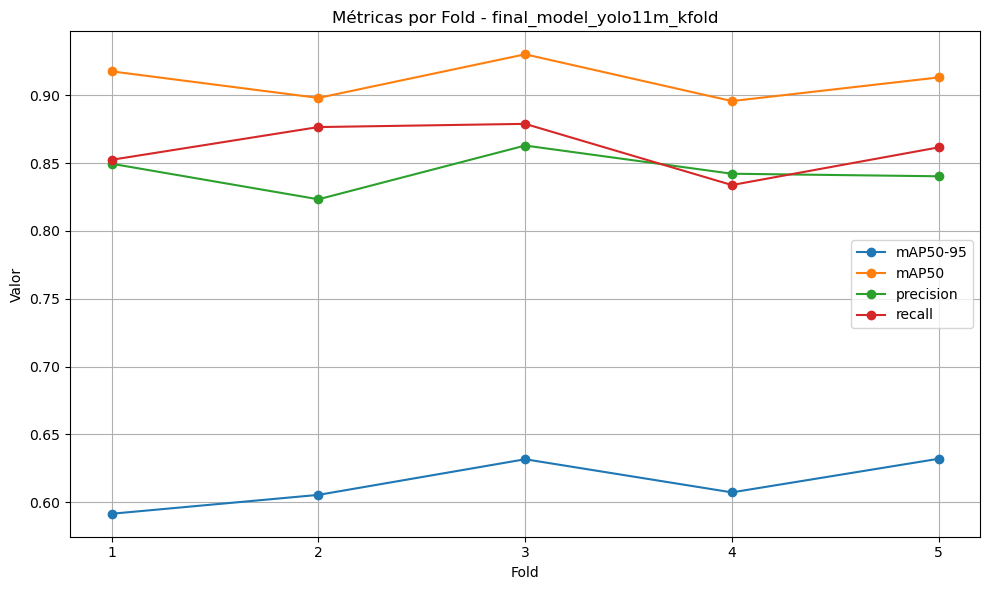

In [12]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [ ]:
# v8
best_params = {
    "lr0": 0.005399484409787433,
    "lrf": 0.003991305878561679,
    "momentum": 0.9062108866694067,
    "weight_decay": 0.00010485387725194633,
    "optimizer": "SGD",
    "warmup_epochs": 5,
    "warmup_momentum": 0.75
}

#v12
# Mejores hiperparámetros:
#   lr0: 0.00023426581058204064
#   lrf: 0.009323621351781481
#   momentum: 0.9162699235041671
#   weight_decay: 0.0008699593128513321
#   optimizer: AdamW

In [6]:
model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **best_params      
)

New https://pypi.org/project/ultralytics/8.3.175 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=7, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00023426581058204064, lrf=0.009323621351781481, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo12s.pt, momentum=0.9162699235041671, mosaic=1.0, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.8 ms, read: 635.0265.2 MB/s, size: 103.5 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov12s\labels.jpg... 
optimizer: AdamW(lr=0.00023426581058204064, momentum=0.9162699235041671) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00085636619858803), 119 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov12s
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.61G      1.955      2.499      1.043        163        704: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all         70        846      0.646      0.375       0.42     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.62G       1.25     0.9717     0.8645        252        704: 100%|██████████| 40/40 [01:04<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all         70        846      0.822      0.778      0.866      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.56G      1.192     0.8549     0.8522        180        704: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all         70        846      0.781      0.836      0.874      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.65G      1.112     0.8413     0.8327        135        704: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

                   all         70        846      0.836      0.852      0.899      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.67G       1.06     0.7692     0.8278        162        704: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all         70        846      0.836      0.835      0.894      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.51G      1.038     0.7447     0.8205        110        704: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all         70        846      0.805      0.866       0.87      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.56G      1.013     0.7299     0.8246        153        704: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all         70        846      0.816      0.877      0.901      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.52G      1.003     0.7093     0.8259        170        704: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all         70        846      0.848      0.857      0.913      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.58G     0.9959     0.7445     0.8169        185        704: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all         70        846      0.841      0.869       0.91      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.68G      1.004     0.7337     0.8333        106        704: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all         70        846      0.851      0.844      0.912      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.65G     0.9799     0.6981     0.8222        109        704: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

                   all         70        846      0.839      0.878      0.916        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.54G     0.9465     0.6953     0.8184        115        704: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all         70        846      0.832      0.894      0.912      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.67G     0.9451     0.6725     0.8244         50        704: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all         70        846      0.825      0.879      0.912      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.6G     0.9421     0.6612     0.8146        129        704: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all         70        846       0.82      0.901      0.913      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.69G     0.9294     0.6514     0.8119        136        704: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all         70        846      0.827      0.894      0.923      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.54G     0.9322     0.6491     0.8155        115        704: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all         70        846      0.829      0.902       0.92      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.55G     0.9065     0.6411     0.8118        133        704: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all         70        846      0.856      0.869      0.927      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       3.7G     0.9259     0.6279     0.8154        247        704: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all         70        846      0.815      0.912      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       3.6G     0.8836     0.6337      0.811        157        704: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all         70        846      0.838      0.884      0.923      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.53G     0.9186     0.6459     0.8151         66        704: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all         70        846       0.87      0.843      0.912      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.51G     0.9287     0.6266     0.8138         82        704: 100%|██████████| 40/40 [00:35<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all         70        846      0.871      0.847      0.923      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.54G     0.8747     0.6167     0.8037        159        704: 100%|██████████| 40/40 [00:18<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all         70        846      0.852      0.877      0.933      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.53G     0.8434     0.5986      0.805        149        704: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all         70        846      0.839      0.901       0.93      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.58G     0.8857     0.6161     0.8074         94        704: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all         70        846      0.843      0.888      0.929      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.51G     0.8678     0.6038     0.8114        292        704: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all         70        846      0.849      0.884      0.931      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.54G     0.8643     0.6119     0.8131        108        704: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all         70        846      0.867      0.877      0.936       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.52G     0.8582     0.5904     0.8101        219        704: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all         70        846      0.857      0.889      0.936      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.55G     0.8653     0.5973     0.8153        166        704: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all         70        846      0.861      0.875      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.62G      0.852     0.6146     0.8112        222        704: 100%|██████████| 40/40 [01:03<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all         70        846      0.857      0.879      0.934      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.53G     0.8774     0.6055     0.8118        137        704: 100%|██████████| 40/40 [00:23<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all         70        846       0.88      0.847      0.928       0.73


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.48G     0.8477     0.6404     0.8133        134        704: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all         70        846       0.87      0.868      0.933      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.55G     0.8175     0.6038     0.8068         58        704: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all         70        846      0.856      0.882      0.934      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       3.5G     0.8381     0.5937      0.805        107        704: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all         70        846      0.861      0.877      0.939       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.47G     0.8046     0.5788     0.8079         70        704: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

                   all         70        846      0.868      0.874      0.937      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.48G     0.7926     0.5779     0.8076        124        704: 100%|██████████| 40/40 [00:42<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

                   all         70        846        0.9      0.844      0.939      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.52G     0.8077     0.5828     0.8155         58        704: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all         70        846      0.889      0.849       0.94      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.57G     0.7732     0.5567     0.8065         53        704: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all         70        846      0.881      0.863      0.937      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.52G     0.7828     0.5597     0.8018         69        704: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all         70        846      0.874      0.874      0.941      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.48G     0.7896     0.5499     0.7985        133        704: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all         70        846      0.876       0.87       0.94      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.55G     0.7643     0.5336     0.8071         62        704: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all         70        846      0.879      0.869      0.939      0.741



40 epochs completed in 0.476 hours.
Optimizer stripped from runs\detect\final_model_yolov12s\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\final_model_yolov12s\weights\best.pt, 18.9MB

Validating runs\detect\final_model_yolov12s\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


                   all         70        846      0.874      0.874      0.941      0.743
Speed: 0.7ms preprocess, 12.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\final_model_yolov12s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002387A2E3DD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

Error al cargar runs/detect/final_model_yolov9s/results.csv: [Errno 2] No such file or directory: 'runs/detect/final_model_yolov9s/results.csv'
Error al cargar runs/detect/final_model_yolov10n/results.csv: [Errno 2] No such file or directory: 'runs/detect/final_model_yolov10n/results.csv'
Error al cargar runs/detect/final_model_yolov11s/results.csv: [Errno 2] No such file or directory: 'runs/detect/final_model_yolov11s/results.csv'


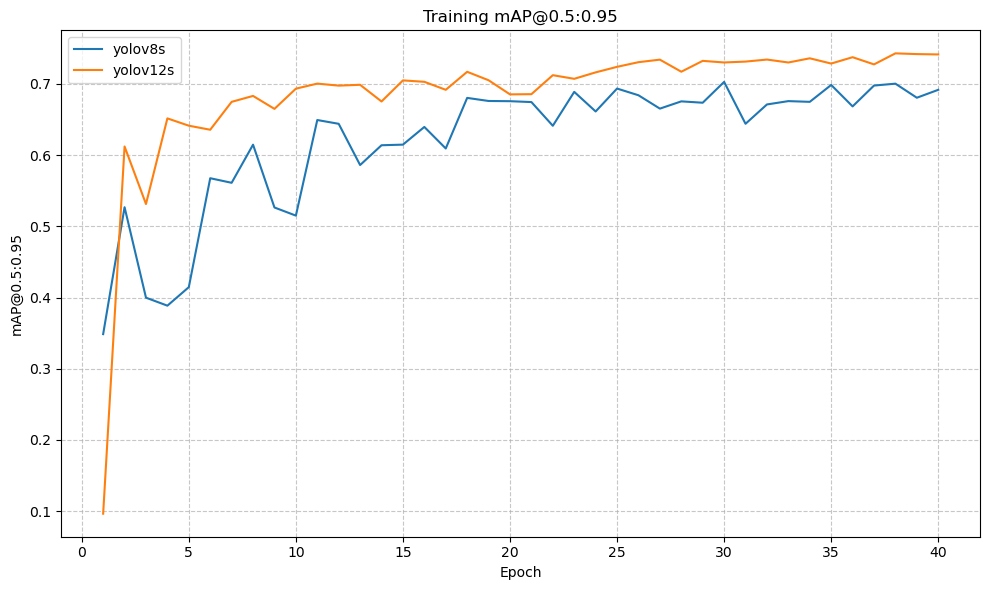

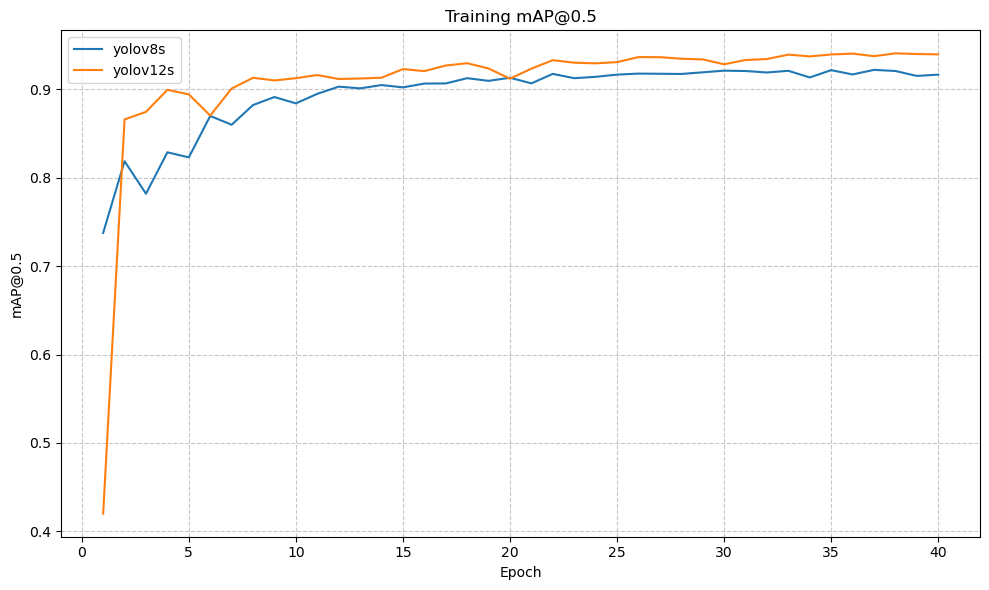

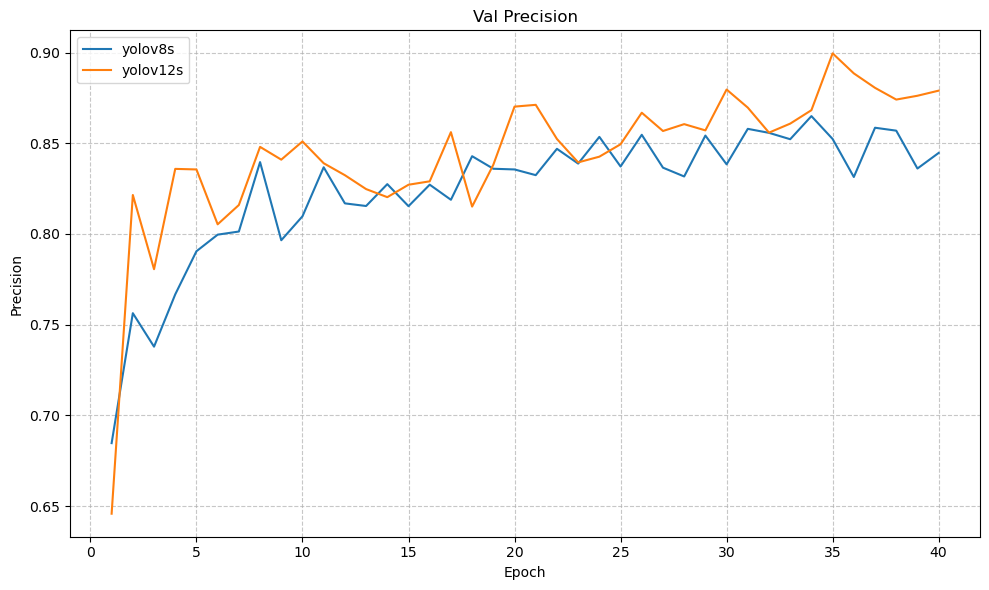

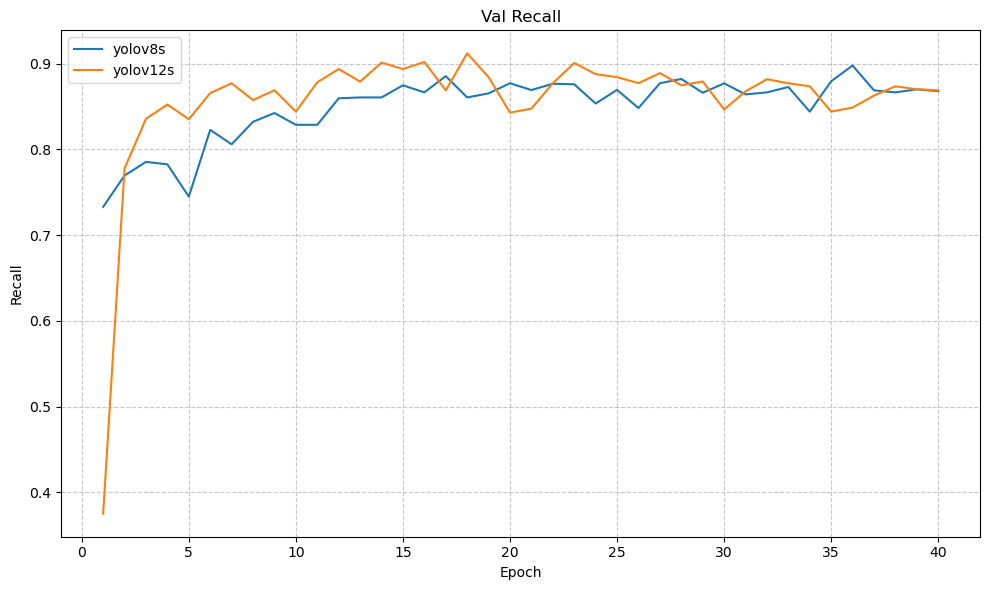

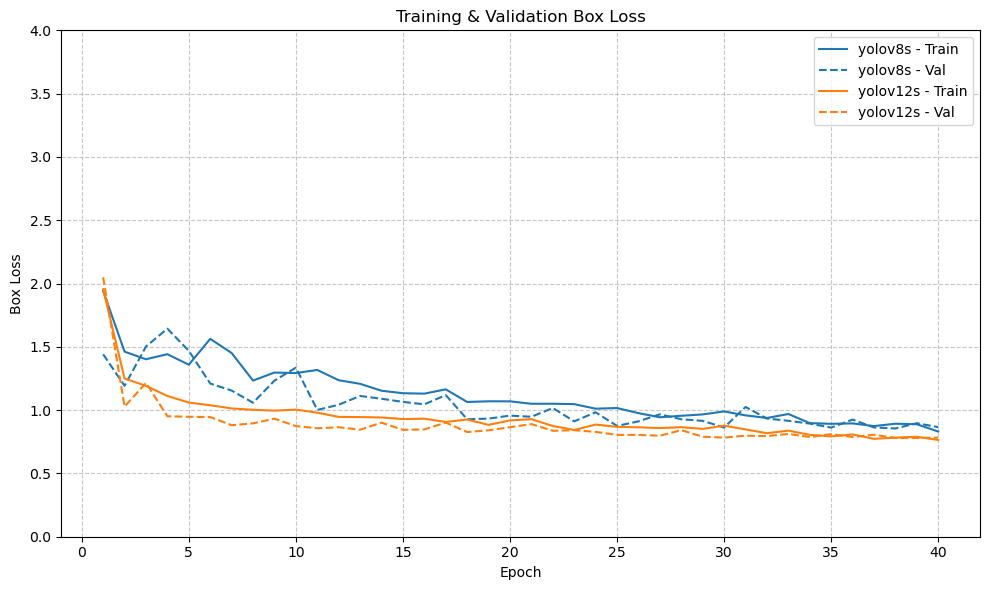

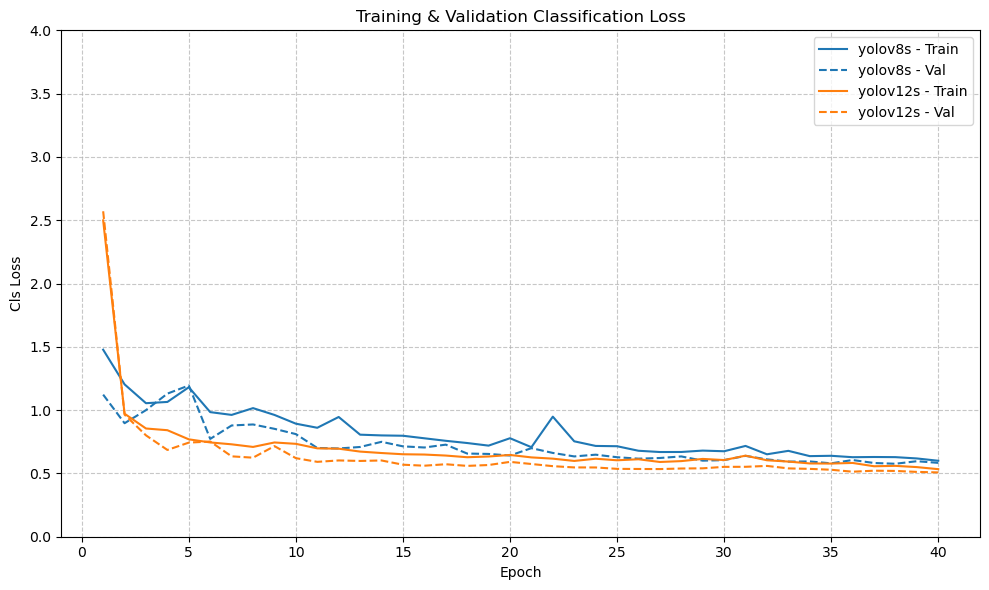

In [3]:
plots_dir = 'yolo_output/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [15]:
def process_images(directorio_entrada, directorio_referencia, directorio_salida, modelo_path):
    """
    Process all images in a directory with YOLO and compare with reference images.
    
    Args:
        directorio_entrada: Path to directory containing input images
        directorio_referencia: Path to directory containing reference images
        directorio_salida: Path to save output comparison images
        modelo_path: Path to YOLO model weights
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
        print(f"Directorio creado: {directorio_salida}")
    else:
        print(f"Usando directorio de salida: {directorio_salida}")
    
    modelo_personalizado = YOLO(modelo_path)
    
    archivos_entrada = [f for f in os.listdir(directorio_entrada) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not archivos_entrada:
        print(f"No se encontraron imágenes en {directorio_entrada}")
        return
    
    print(f"Procesando {len(archivos_entrada)} imágenes...")
    
    for nombre_archivo in archivos_entrada:
        print(f"Procesando: {nombre_archivo}")
        ruta_imagen = os.path.join(directorio_entrada, nombre_archivo)
        
        nombre_base = os.path.splitext(nombre_archivo)[0]
        nombre_referencia = f"{nombre_base}_.jpg"
        ruta_imagen_referencia = os.path.join(directorio_referencia, nombre_referencia)
        
        if not os.path.exists(ruta_imagen_referencia):
            print(f"Advertencia: No se encontró la imagen de referencia {nombre_referencia}")
            ruta_imagen_referencia = None
        
        resultados = modelo_personalizado(ruta_imagen)
        
        for r in resultados:
            num_detecciones = len(r.boxes)

            im_array = r.plot(labels=False, conf=True)

            font = cv2.FONT_HERSHEY_SIMPLEX
            texto_contador = f"{num_detecciones}"

            # Calculamos el tamaño del texto para posicionarlo correctamente
            textSize = cv2.getTextSize(texto_contador, font, 0.8, 2)[0]
            
            # Posicionamos en la esquina superior derecha con un margen de 20px
            text_x = im_array.shape[1] - textSize[0] - 20
            text_y = 30  # 30px desde la parte superior
            
            # Dibujamos el texto
            cv2.putText(im_array, texto_contador, (text_x, text_y), font, 0.8, (255, 255, 255), 2)
            
            if ruta_imagen_referencia:
                img_referencia = cv2.imread(ruta_imagen_referencia)
                
                h1, w1 = im_array.shape[:2]
                h2, w2 = img_referencia.shape[:2]
                
                if h1 != h2:
                    if h1 > h2:
                        new_w2 = int(w2 * (h1 / h2))
                        img_referencia = cv2.resize(img_referencia, (new_w2, h1))
                    else:
                        new_w1 = int(w1 * (h2 / h1))
                        im_array = cv2.resize(im_array, (new_w1, h2))
                
                img_combinada = cv2.hconcat([im_array, img_referencia])
                
                cv2.line(img_combinada, (im_array.shape[1], 0), (im_array.shape[1], img_combinada.shape[0]), (90, 70, 255), 2)
                
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(img_combinada, "YOLO", (10, 30), font, 1, (0, 255, 0), 2)
                cv2.putText(img_combinada, "IR", (im_array.shape[1] + 10, 30), font, 1, (0, 255, 0), 2)
                
                ruta_salida = os.path.join(directorio_salida, f"comparacion_{nombre_archivo}")
                cv2.imwrite(ruta_salida, img_combinada)
            else:
                ruta_salida = os.path.join(directorio_salida, f"yolo_{nombre_archivo}")
                cv2.imwrite(ruta_salida, im_array)
            
    print(f"Procesamiento completado. Resultados guardados en {directorio_salida}")

Añadir la evaluación sobre el conjunto de test

In [16]:
modelo_path = '.\\runs\\detect\\final_model_optunav12s\\weights\\best.pt'

# DEFAULT dataset
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\INPUT DEFAULT",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\OUTPUT_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\YOLO_NEW",
    modelo_path
)

# TEST 2
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\INPUT TEST_2",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\OUTPUT_TEST 2_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\YOLO_NEW",
    modelo_path
)

# TEST 3
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\INPUT_TEST 3",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\OUTPUT_TEST 3_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\YOLO_NEW",
    modelo_path
)

# TEST 4
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\INPUT_TEST 4",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\OUTPUT_TEST 4_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\YOLO_NEW",
    modelo_path
)

Usando directorio de salida: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\YOLO_NEW
Procesando 94 imágenes...
Procesando: 110.jpg
Advertencia: No se encontró la imagen de referencia 110_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\110.jpg: 576x704 1 cell, 84.9ms
Speed: 4.5ms preprocess, 84.9ms inference, 11.1ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 116.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\116.jpg: 576x704 36 cells, 30.8ms
Speed: 4.1ms preprocess, 30.8ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 124.jpg
Advertencia: No se encontró la imagen de referencia 124_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAU

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: '..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\INPUT TEST_2'

añadir kfold y una función general que importe con un import para generar una carpeta con los resultados de la evaluación de cada imagen del test/defalut/eval_empresa 

probar con optuna varios batch con: ``batch = trial.suggest_categorical('batch', [4, 8, 12])`` con los modelos s.

Probar a entrenar Yolo con capas de atención y mucho más personalizados algunos modelos.

 hacer RFHF con yolo?

| Modelo           |  IoU  |  59 imagen  |  61 imagen  |  219 imagen  |  369 imagen  |
|------------------|:-----:|:-----------:|:-----------:|:------------:|:------------:|
| yolov8s          |  0.5  |           |           |           |           |
| yolov8s          |  0.7  |           |           |           |           |
| yolov9s          |  0.5  |     ❌      |     ❌      |      ❌     |      ❌     |
| yolov9s          |  0.7  |     ✅      |     ✅      |      ❌     |      ❌     |
| yolov10n         |  0.5  |     ✅      |     ❌      |      ❌     |      ❌     |
| yolov10n         |  0.7  |     ✅      |     ✅      |      ❌     |      ✅     |
| yolov11s         |  0.5  |     ✅      |     ❌      |      ❌     |      ✅     |
| yolov11s         |  0.7  |     ✅      |     ✅      |      ✅     |      ✅     |
| yolov12s         |  0.5  |     ✅      |     ✅      |      ✅     |      ✅     |
| yolov12s         |  0.7  |     ✅      |     ✅      |      ✅     |      ✅     |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file

comentar en la memoria el uso de linters como ruff